### Импорты


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Данные

In [ ]:
df.shape

(1104, 2)

In [ ]:
ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time']) # Просмотры рекламы за час
currency = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time']) # Трата внутриигровой валюты в день

In [ ]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [ ]:
currency.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


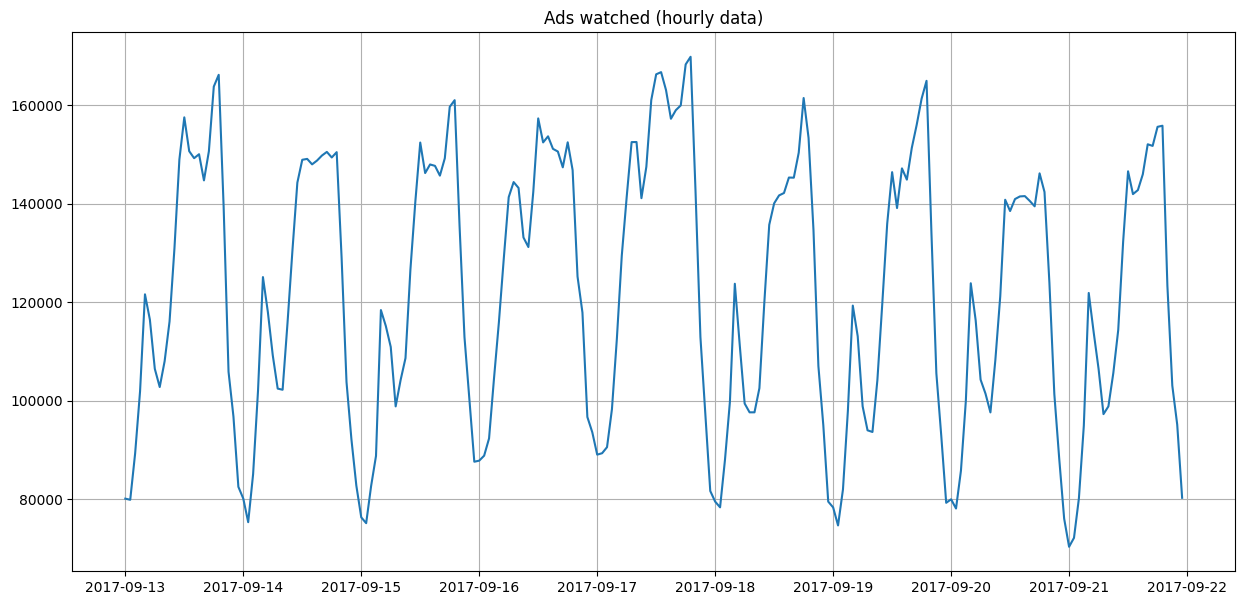

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

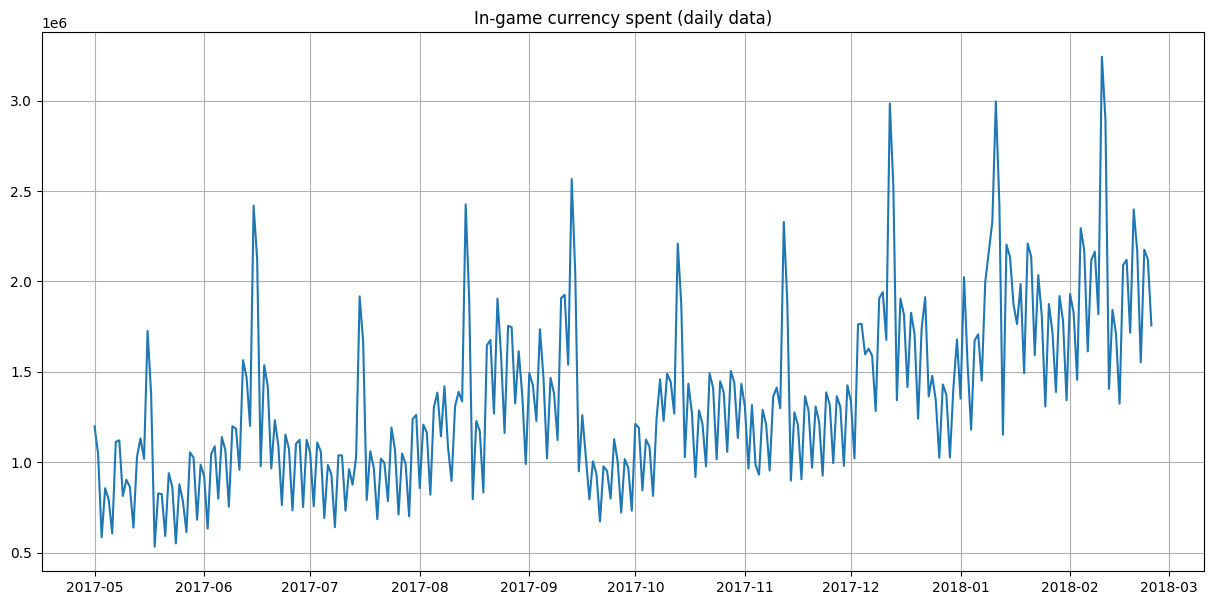

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

### Скользящее среднее



$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [ ]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Сглаживание с окном 4

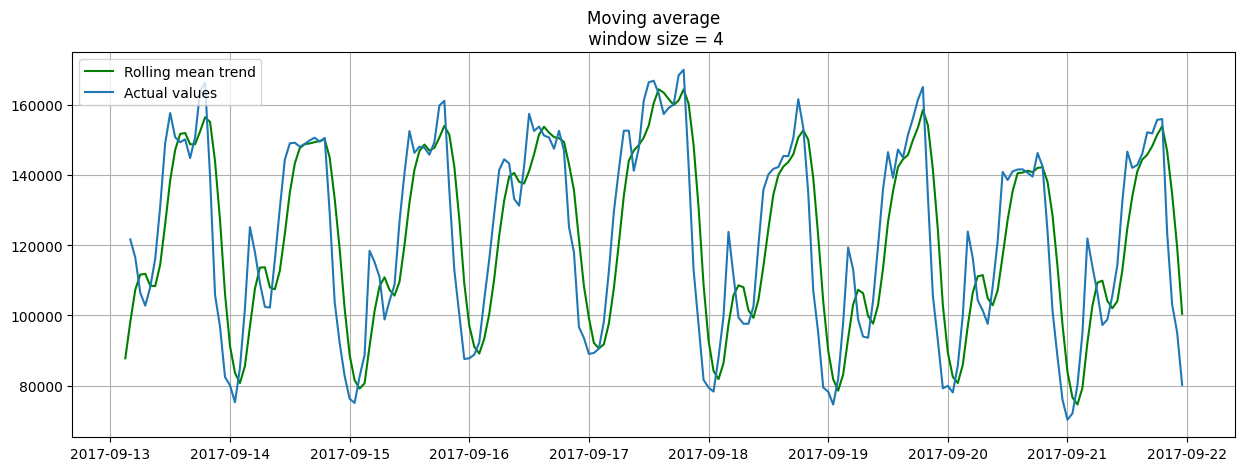

In [ ]:
plotMovingAverage(ads, 4)

Сглаживание с окном 12

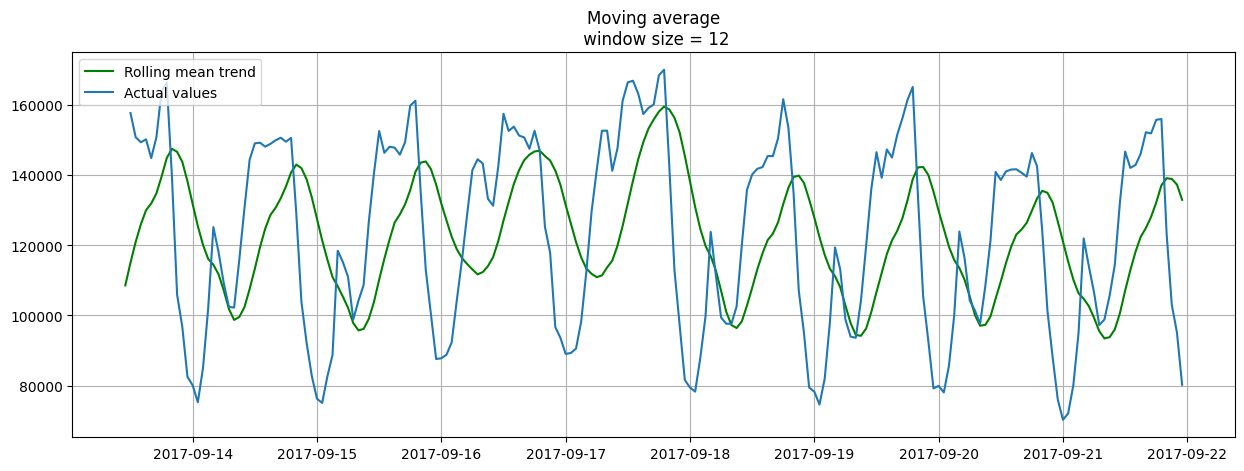

In [ ]:
plotMovingAverage(ads, 12)

Сглаживание с окном 24 - дневной тренд

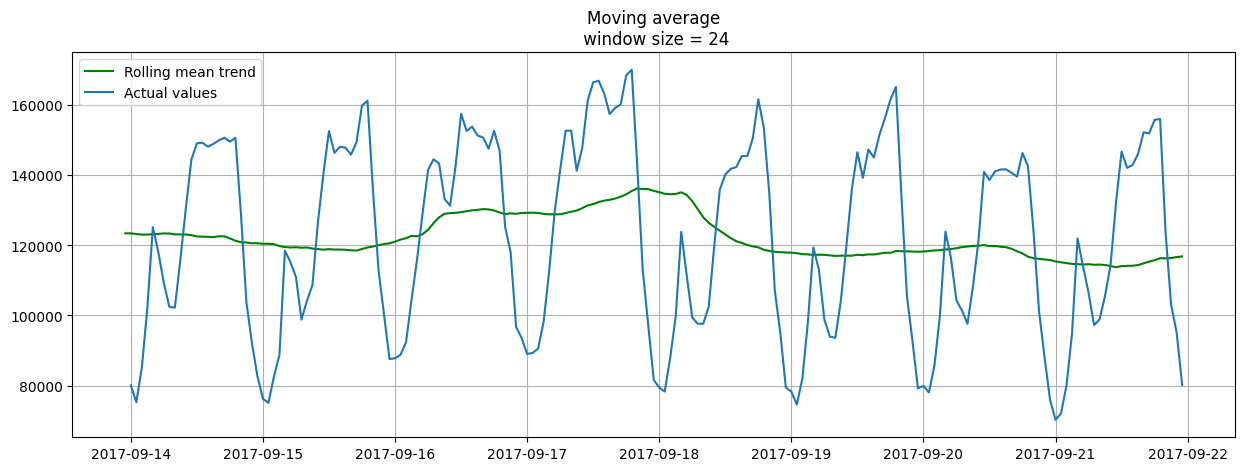

In [ ]:
plotMovingAverage(ads, 24)

Добавим доверительные интервалы

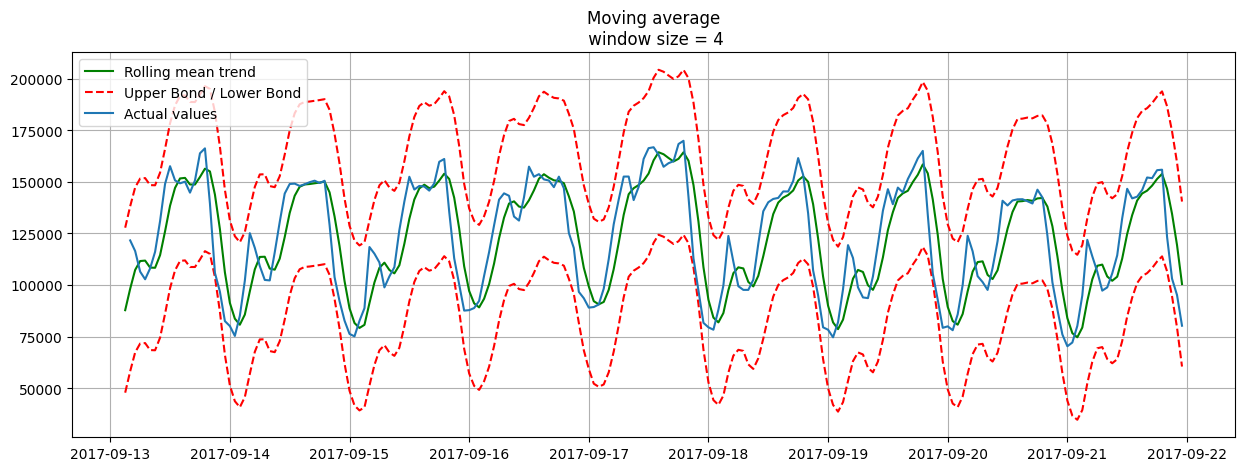

In [ ]:
plotMovingAverage(ads, 4, plot_intervals=True)

#### Детекция аномалий

Добавим вручную аномалию


In [ ]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads

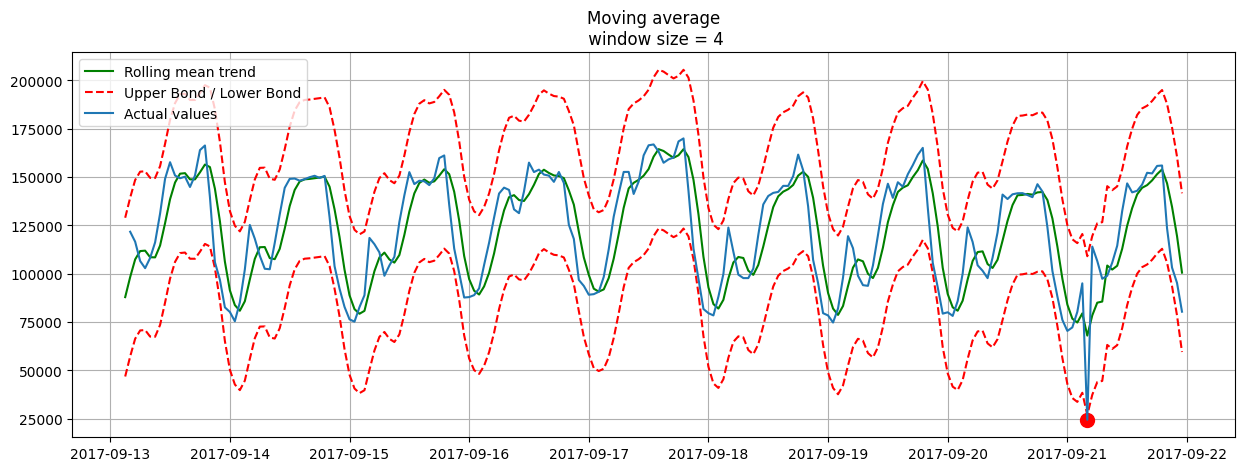

In [ ]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

Проверим на втором временном ряду

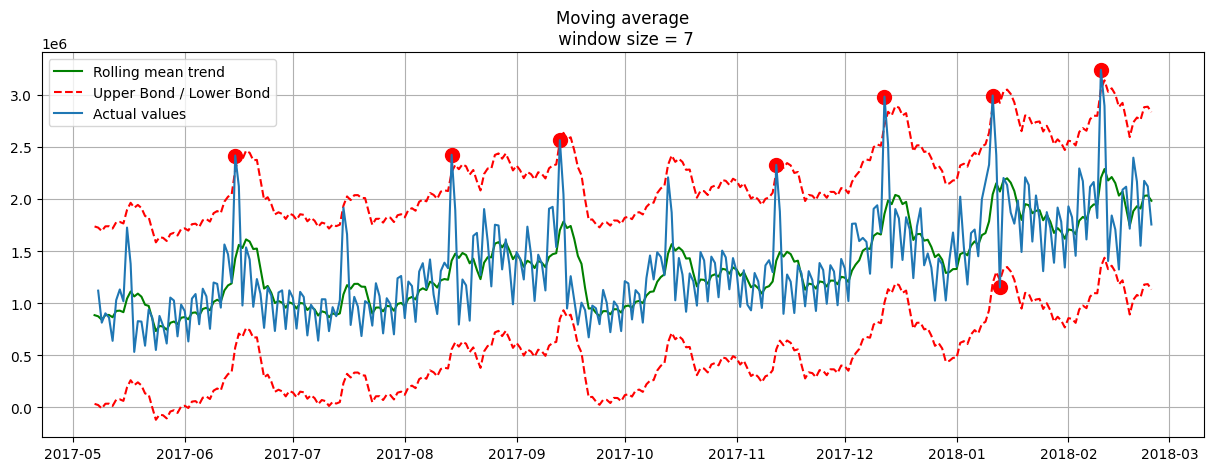

In [ ]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True)

Каждый 30-дневный пик отмечен как аномалия...

### Взвешенное скользящее среднее


$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [ ]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [ ]:
weighted_average(ads, [0.6, 0.3, 0.1])

87025.5

### Экспоненциальное сглаживание

В этом подхоже мы экспоненциально уменьшаем веса по мере продвижения назад во времени.
$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Вес $\alpha$ называется коэффициентом сглаживания. Он определяет, насколько быстро мы «забудем» последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем большее влияние оказывают предыдущие наблюдения и тем более гладким является ряд.

Экспоненциальность скрыта в рекурсивности функции - мы каждый раз умножаем на $(1-\alpha)$, что уже содержит умножение на $(1-\alpha)$ предыдущих значений.

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

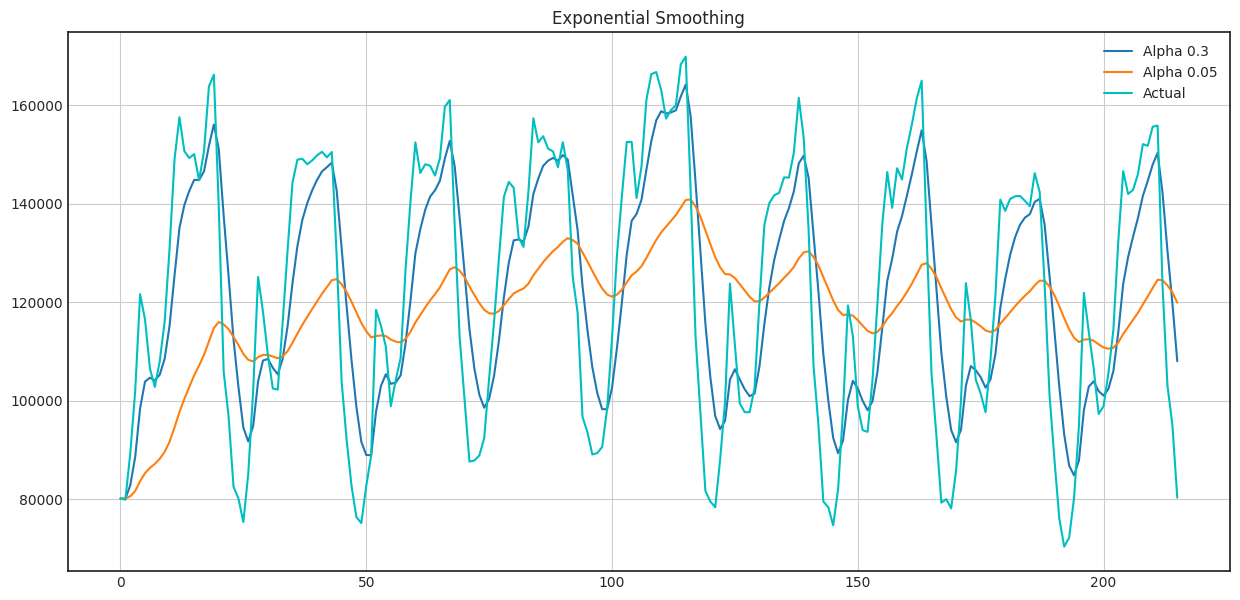

In [ ]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

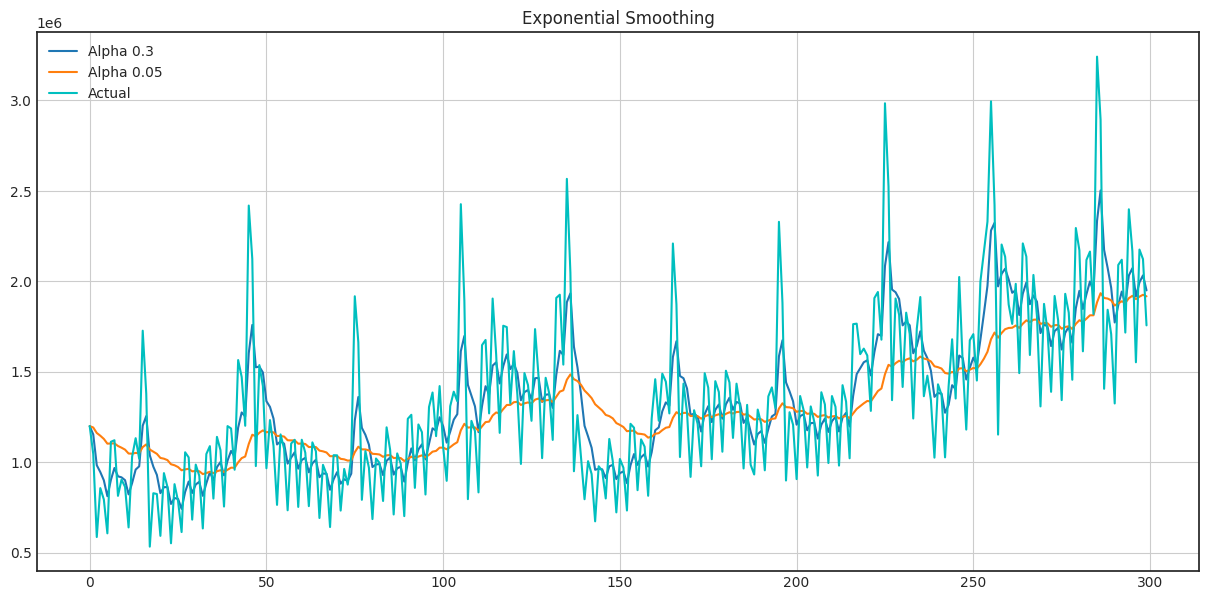

In [ ]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

### Time-series cross validation



<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

### Статистические модели

#### Стационарность

В чем проблема в этих рядах?

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>


<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>


<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>


#### Белый шум

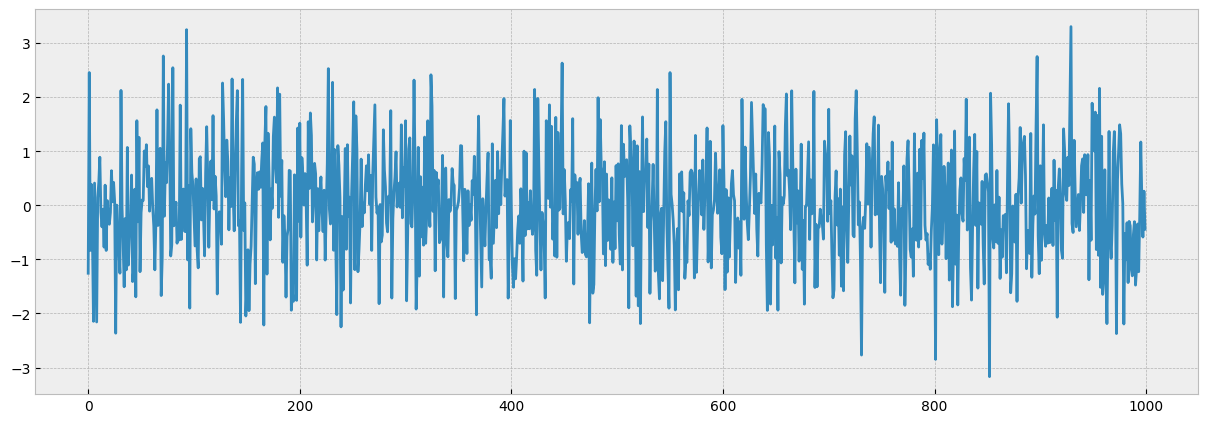

In [ ]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

#### Тест Дики-Фуллера

(Dickey-Fuller test)

- Нулевая гипотеза предполагает, что процесс нестационарный
- Альтернативная гипотеза соответственно говорит об обратном
- Для принятия решения смотрим на p-value


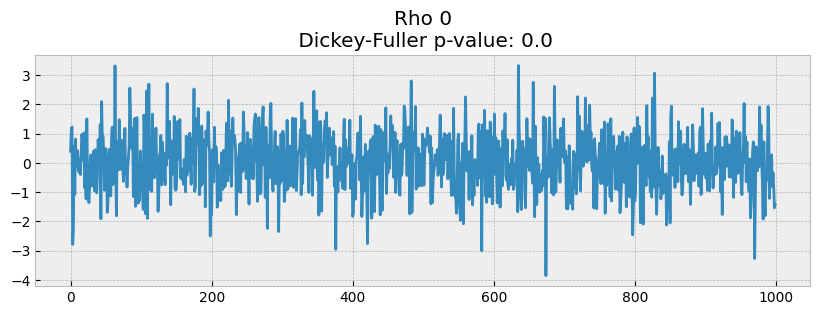

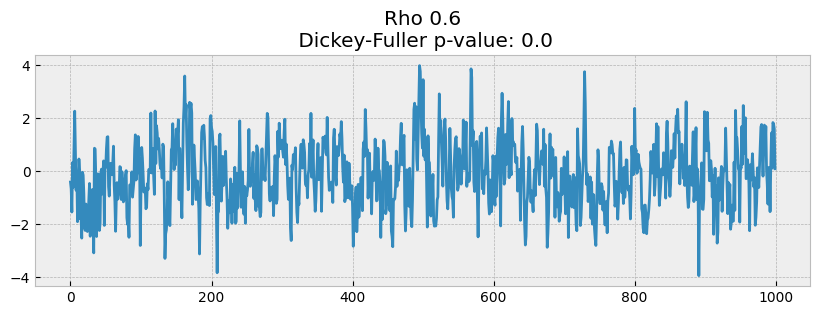

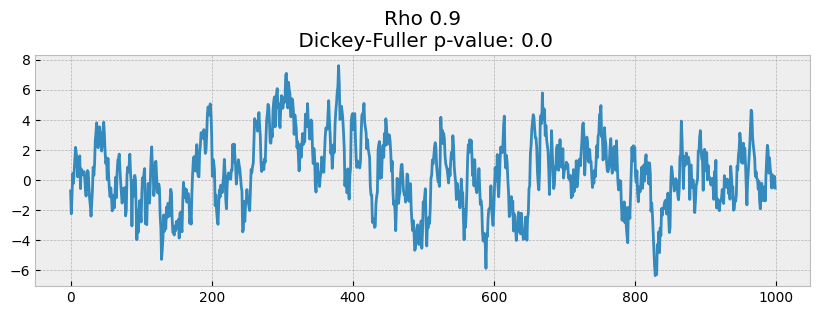

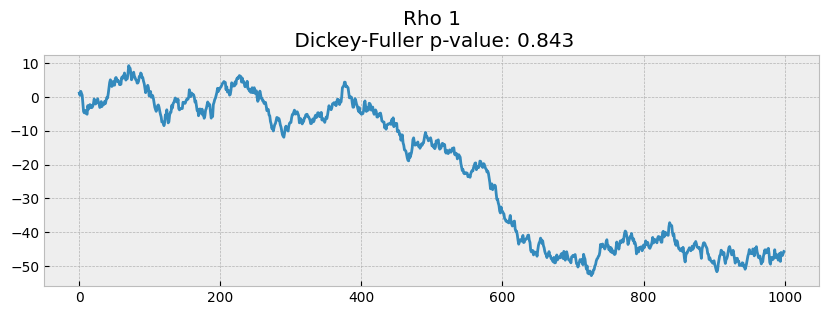

In [ ]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

#### Избавляемся от нестационарности и строим ARIMA

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

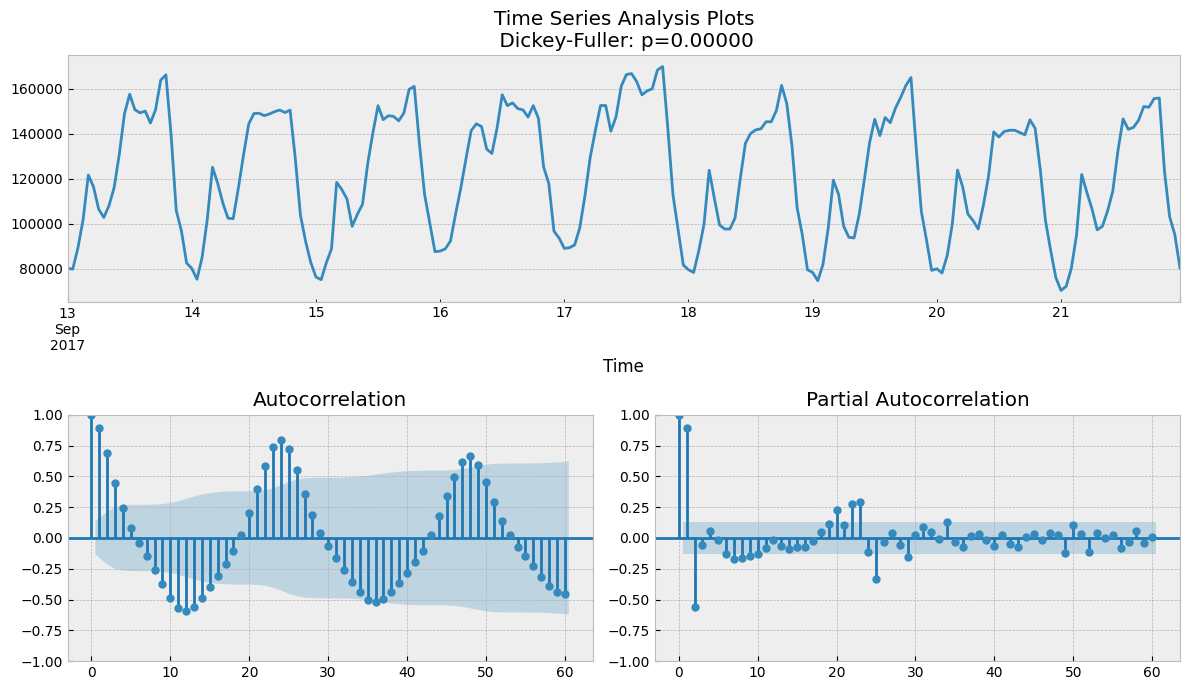

In [ ]:
tsplot(ads.Ads, lags=60)

С рядом почти все хорошо, но есть сезонность - избавимся от нее, вычитая сезонные лаги

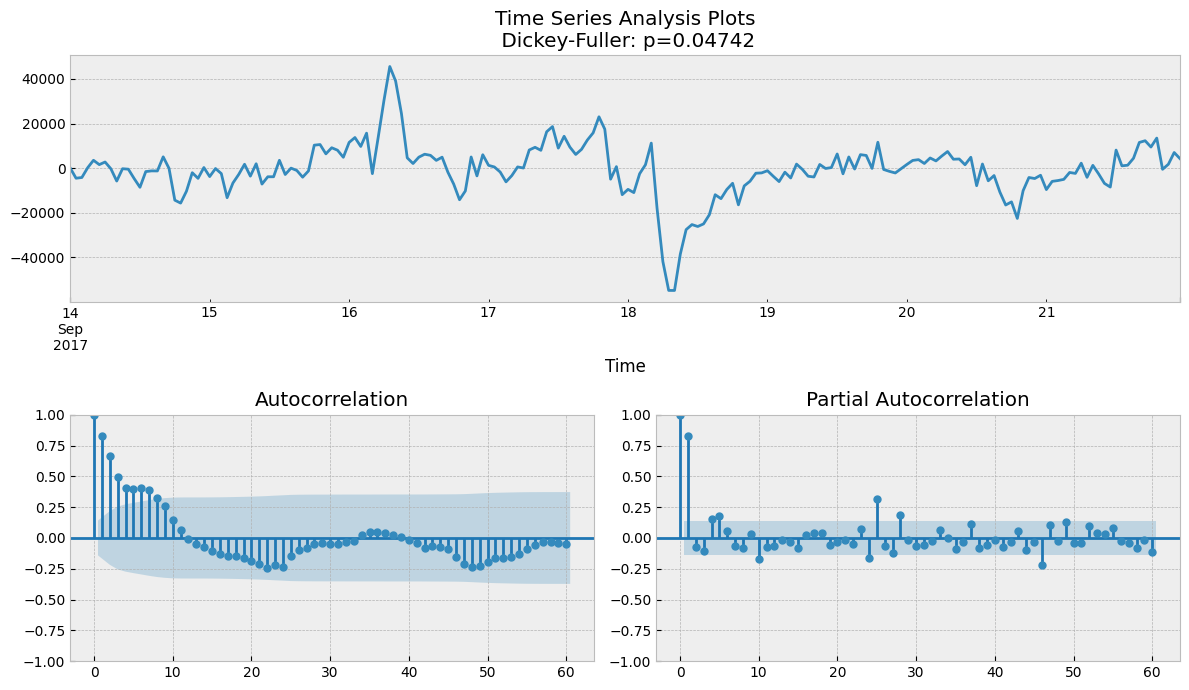

In [ ]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

Все стало намного лучше, но автокорреляционная функция по-прежнему имеет слишком много значительных лагов. Чтобы их удалить, проведем **дифференцирование**

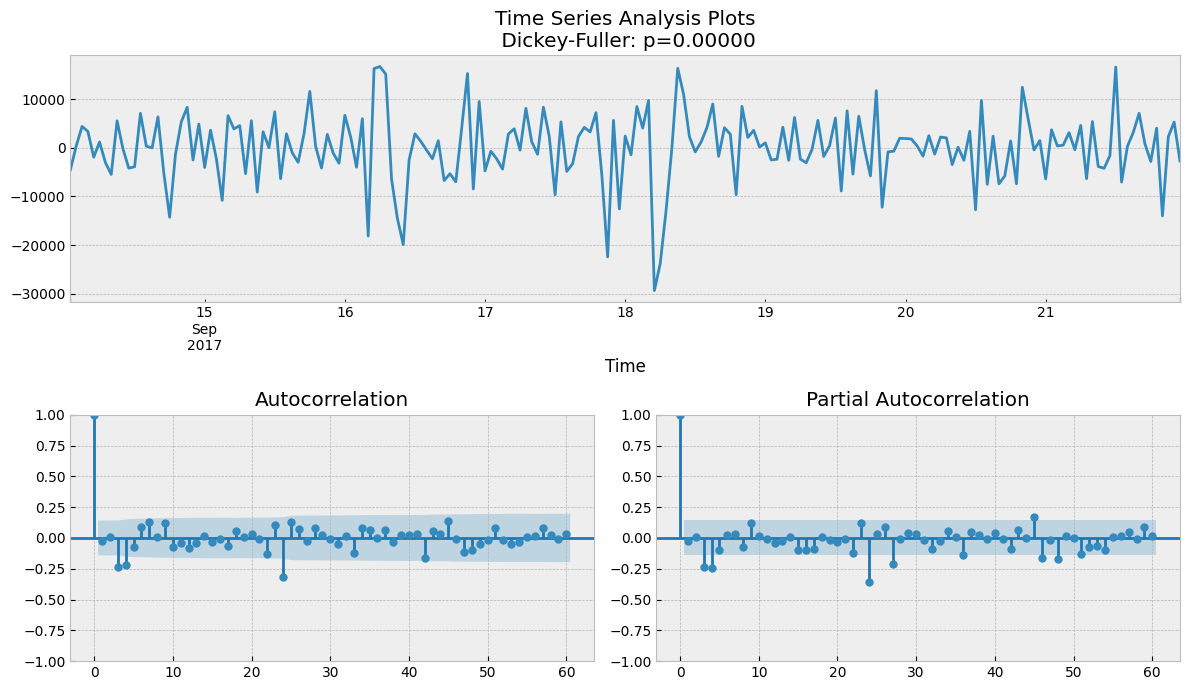

In [ ]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

#### Вспоминаем ARIMA и еще кое-что

$SARIMA(p, d, q)(P, D, Q, s)$ - модель сезонной авторегрессии скользящего среднего:

- $AR(p)$ - модель авторегрессии, т.е. регрессия временного ряда на самого себя. Основное предположение состоит в том, что значения текущего ряда зависят от его предыдущих значений с некоторым лагом (или несколькими лагами). Максимальный лаг в модели обозначается как $p$. Чтобы определить начальный $p$, нужно посмотреть на график PACF и найти самый большой значимый лаг, после которого **большинство** других лагов становятся незначительными.
- $MA(q)$ - модель скользящего среднего. Ммоделируем ошибку временного ряда, опять же с предположением, что текущая ошибка зависит от предыдущей с некоторой задержкой, которая называется $q$. Начальное значение можно найти на графике ACF, используя ту же логику, что и раньше.

$AR(p) + MA(q) = ARMA(p, q)$


- $I(d)$ - порядок интегрирования. Это просто число несезонных различий, необходимое для того, чтобы ряд стал стационарным. В нашем случае это всего лишь 1, потому что мы использовали первые разности.

- $S(s)$ - отвечает за сезонность и равен длине сезонного периода ряда.

При этом у нас есть три параметра: $(P, D, Q)$

- $P$ - порядок авторегрессии для сезонной составляющей модели, который можно получить из PACF. Но нужно смотреть на количество значительных лагов, кратных продолжительности сезона. Например, если период равен 24 и мы видим, что 24-й и 48-й лаги значимы в PACF, это означает, что начальный $P$ должен быть равен 2.

- $Q$ - аналогичная логика с использованием вместо этого графика ACF.

- $D$ - порядок сезонного интегрирования. Оно может быть равно 1 или 0, в зависимости от того, применялись ли сезонные разницы или нет.

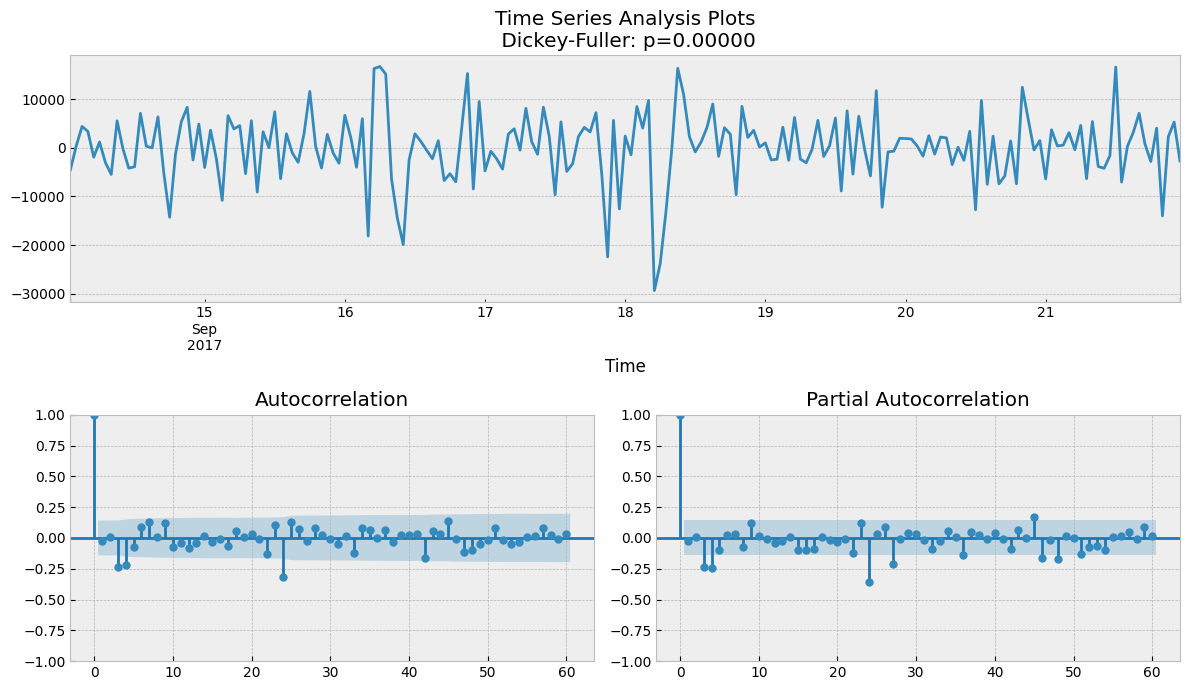

In [ ]:
tsplot(ads_diff[24+1:], lags=60)

- $p$, скорее всего, равен 4, поскольку это последнее значительное отставание PACF, после которого большинство других не являются значимыми.
- $d$ равен 1 - порядок дифференцирования
- $q$ должно быть где-то около 4, как видно на ACF.
- $P$ может быть 2, так как 24-й и 48-й лаги на PACF отчасти значительны.
- $D$ снова равен 1, потому что мы провели сезонное дифференцирование
- $Q$, вероятно, равен 1. 24-й лаг по ACF значителен, а 48-й - нет.

Проверим разные варианты

In [ ]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1
qs = range(2, 5)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 2min 26s, sys: 1min 37s, total: 4min 4s
Wall time: 2min 13s


In [ ]:
result_table.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


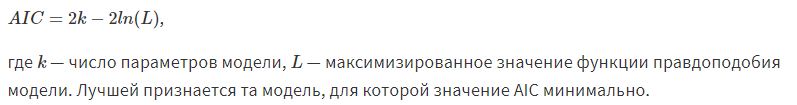

In [ ]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Tue, 20 Feb 2024   AIC                           3888.642
Time:                                      17:57:40   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.55

Посмотрим на остатки

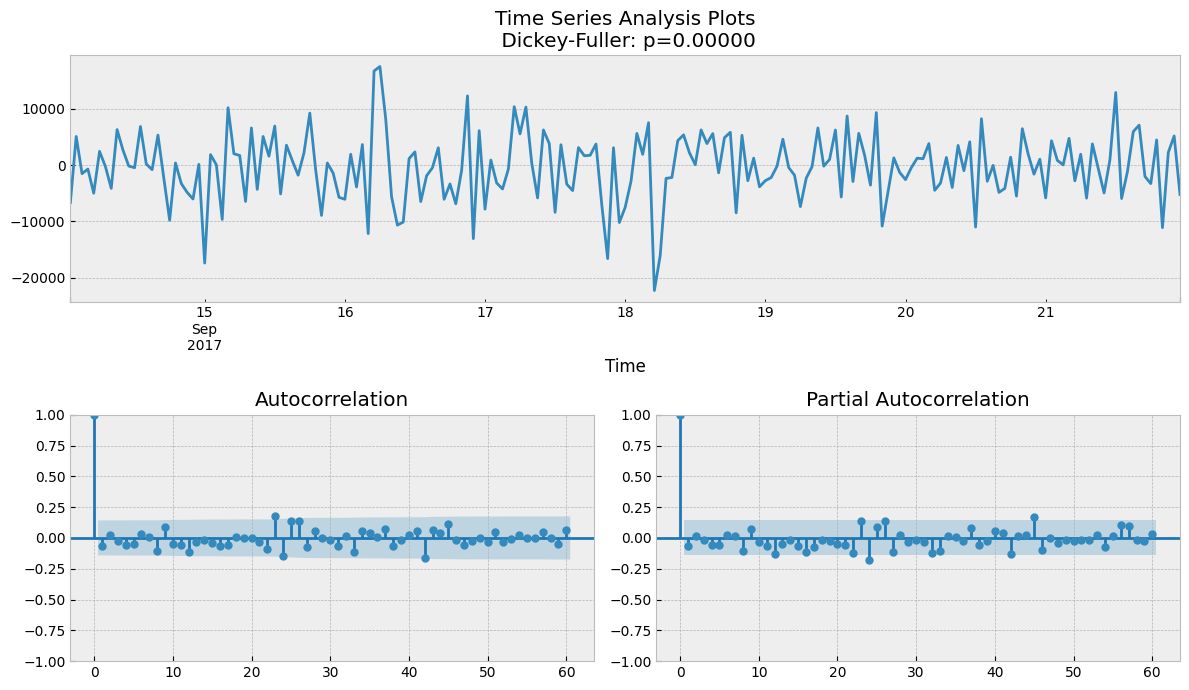

In [ ]:
tsplot(best_model.resid[24+1:], lags=60)

Остатки стационарны

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

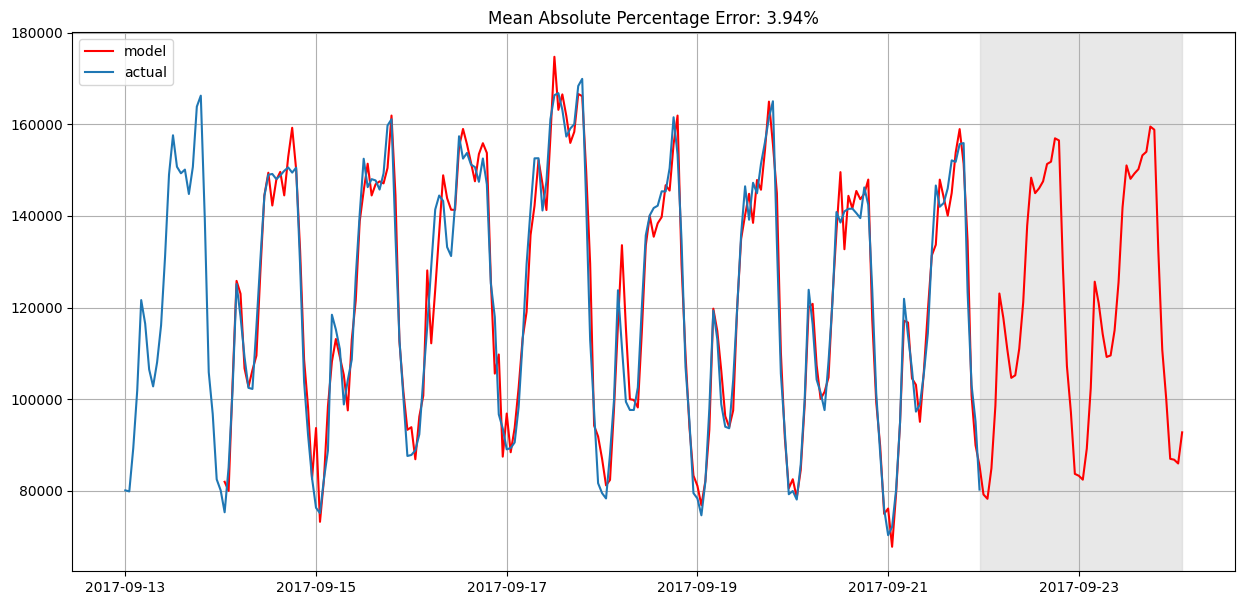

In [ ]:
plotSARIMA(ads, best_model, 50)